In [1]:
!pip3 install tensorflow-estimator==2.6.0

     |████████████████████████████████| 462 kB 6.8 MB/s            
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.4 which is incompatible.
tensorflow-gpu 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.0.1 which is incompatible.


In [2]:
# Tensorflow와 Tensoflow Hub에 있는 이미 학습된 모델을 활용하기 위한 모듈 
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 다운로드하는 데에 사용하는 모듈
import matplotlib.pyplot as plt
import tempfile 
from six.moves.urllib.request import urlopen
from six import BytesIO

# 이미지에 선과 폰트를 넣기 위한 모듈
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Detection하는 데에 소요된 시간을 점검하기 위한 모듈
import time

In [3]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [4]:
#원하는 이미지를 다운로드하고 정해진 가로, 세로 길이에 맞게 이미지를 resizing하는 함수
def download_and_resize_image(url, new_width=256, new_height=256, display=False): 
  
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)  # 이미지 읽기
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [5]:
# Bounding Box를 만드는 함수
def draw_bounding_box_on_image(image, 
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)

# BBox 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [73]:
# 이미지 위에 class 이름과 score를 나타내는 함수
# BBox 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1): 
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

# BBox 그리기 적용
  for i in range(min(boxes.shape[0], max_boxes)):
    if (scores[i] >= min_score).any:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

이미지와 모델 불러오기

Image downloaded to /tmp/tmpmgf5f_qp.jpg.


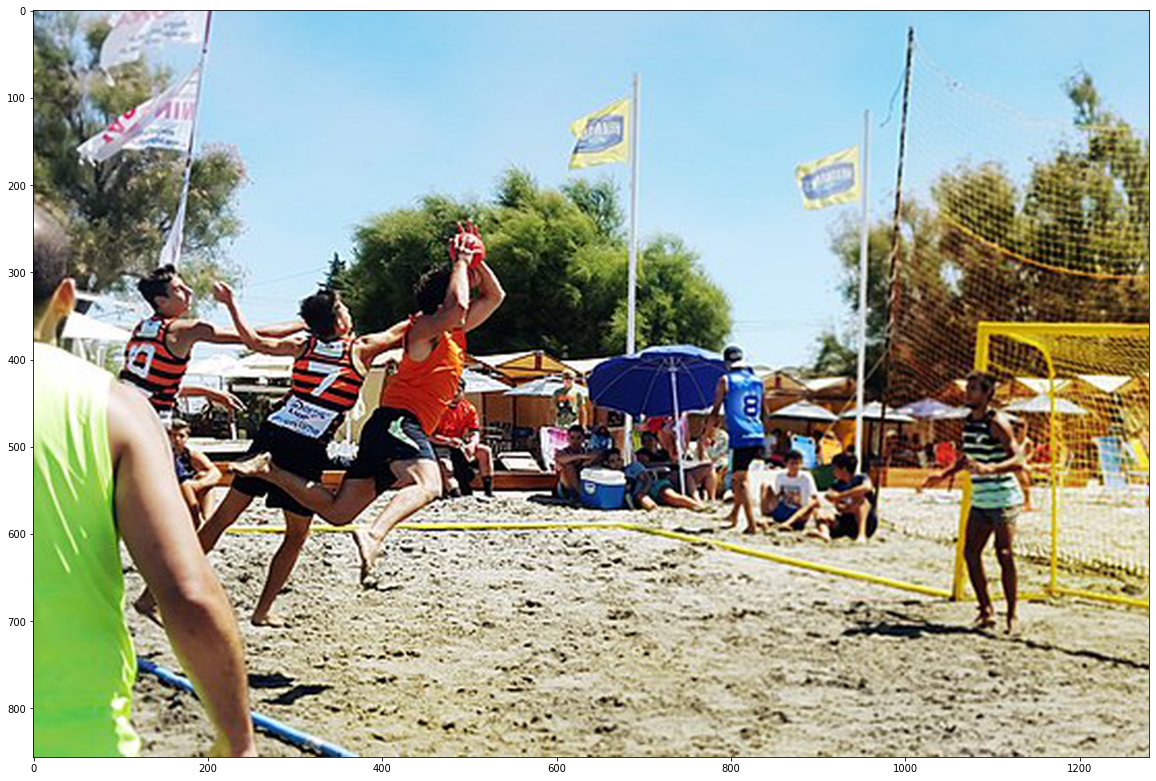

In [48]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Torneo_beach_handball.jpg/640px-Torneo_beach_handball.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)  

In [49]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"  

detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [50]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [67]:
def run_detector(detector, path):
  img = load_img(path) 

  converted_img  = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]

# 소요시간 측정
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

# 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

# 이미지 내 박스로 entity, scores를 추가하여 출력
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Found 100 objects.
Inference time:  33.905353307724


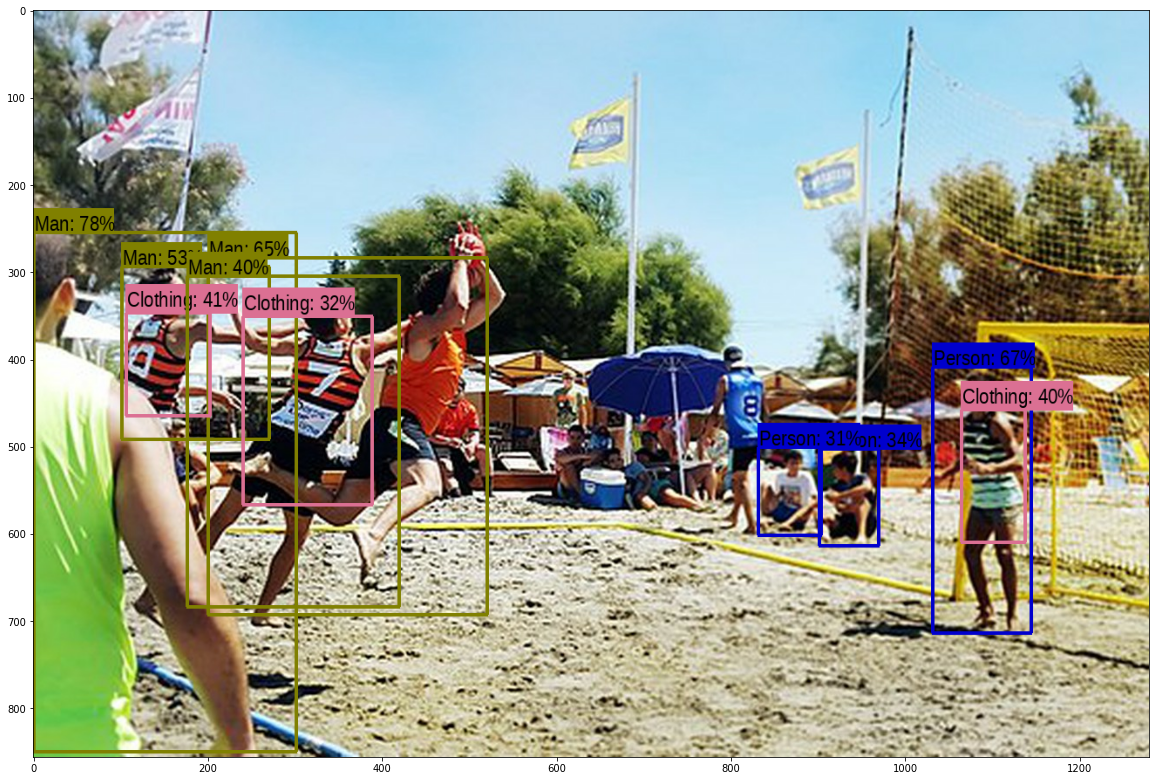

In [52]:
run_detector(detector, downloaded_image_path)

## 다른 이미지 테스트해보기

Image downloaded to /tmp/tmp7e579lh1.jpg.


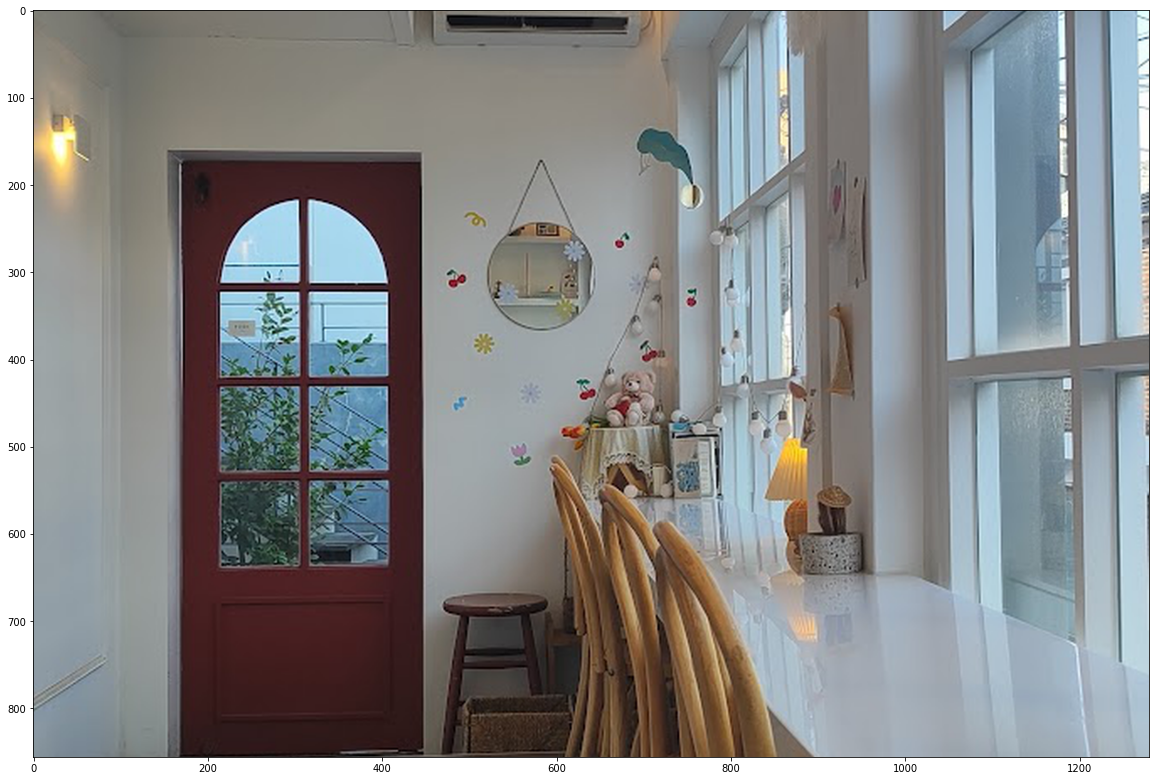

In [56]:
# 이미지 불러오기
basket_url = 'https://lh3.googleusercontent.com/Mo-GTFvK42E_qftyd8tpfY90oIY7lP-psuCLBgb2U_FCJ6xTTdCpyimR2Q6pHKT9c8Iqc3i7deTIgmmaq2mOFfYACZQFsONI4dpXpHDzDoxa_EwkYS_mm-7bWNiolV1era9E4fQRCPXSLckwWi6jHdeGaARcIf7YE6ouo4_qUQqBda3Fc7drIC-Y42UrPR0MFxwBKC2Ng2FZSpUZqIOPG07pz7of6P5GP0-RHV4vTFNuoeAhvbHuQ-EjAa0tgpXcUrKzkBCPVw8-E11DUj8DBToOOZXPoi0BoGfoVKpZMbs-SCWXi3ClorWIi4buwc4l8FOaha1PEwoJ2UcnJ1mvzat-H2Tx50rN8zFw6M37u7A0QXCr6K-NlhrKpuuw4DOCrVEmrgCWdbgFd0nYXP7nwCa7D6GXxFZboD0WTz8QYG3XULyzVr-kjK6TEJtHY91gSXWFiysgi-h2tscPSS2JqQsoEtCYbPvsNmh4B7pK6mh8p83DDj46RA9uEDQ9Ur0GlOm3fzO2mb_dhugvm013ZWLndK1vDQ8hcpz7uDkmJsIQ31ouuuNNr133Tf4E_721_ftYI6K8Vdfu0mpbYTAKH4j5q5ZOQywwqk961ZhFKkq9HsKZPgPnrBtJcNtUm0lC-bHGDTsujyCM6KxZzI1D-wZO2MC-GqgeSVGo3fadiwocdbrVm130cqSKWT8q1W2TWcumH9icpAf8SvWOQhWqxT3zCA6AF3GmDOQUfu8pmVonniObWQfy7lJFJmSXD3xIYVRfGyRtGJFqqc0F4kWRDX6LvQfoDRte1-yJyJy6JI2Nf_KbVD9BwhvKDKzxALxODYOb7orpyltqA4NYLkxtakKpJw13ijX3PaldDrttTNEVhzyNMJQ-UG0AyooAKCxUsPN6urktagRB7P4aPi7yRdVZMu2hwqShUwCDlR_8BDlZmVgmWg=w663-h1179-s-no?authuser=0'
downloaded_image_path = download_and_resize_image(basket_url, 1280, 856, True) 

Found 100 objects.
Inference time:  1.4336028099060059


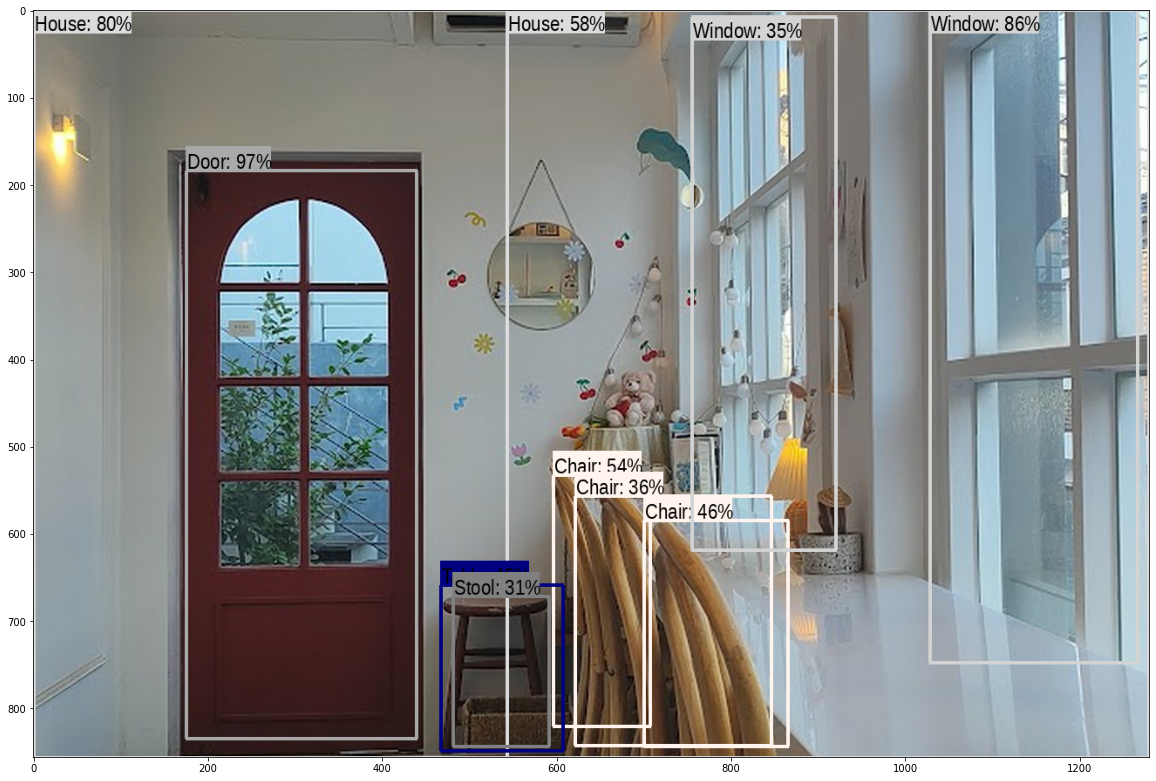

In [57]:
# 테스트
run_detector(detector, downloaded_image_path)

Image downloaded to /tmp/tmp21wu5y6e.jpg.


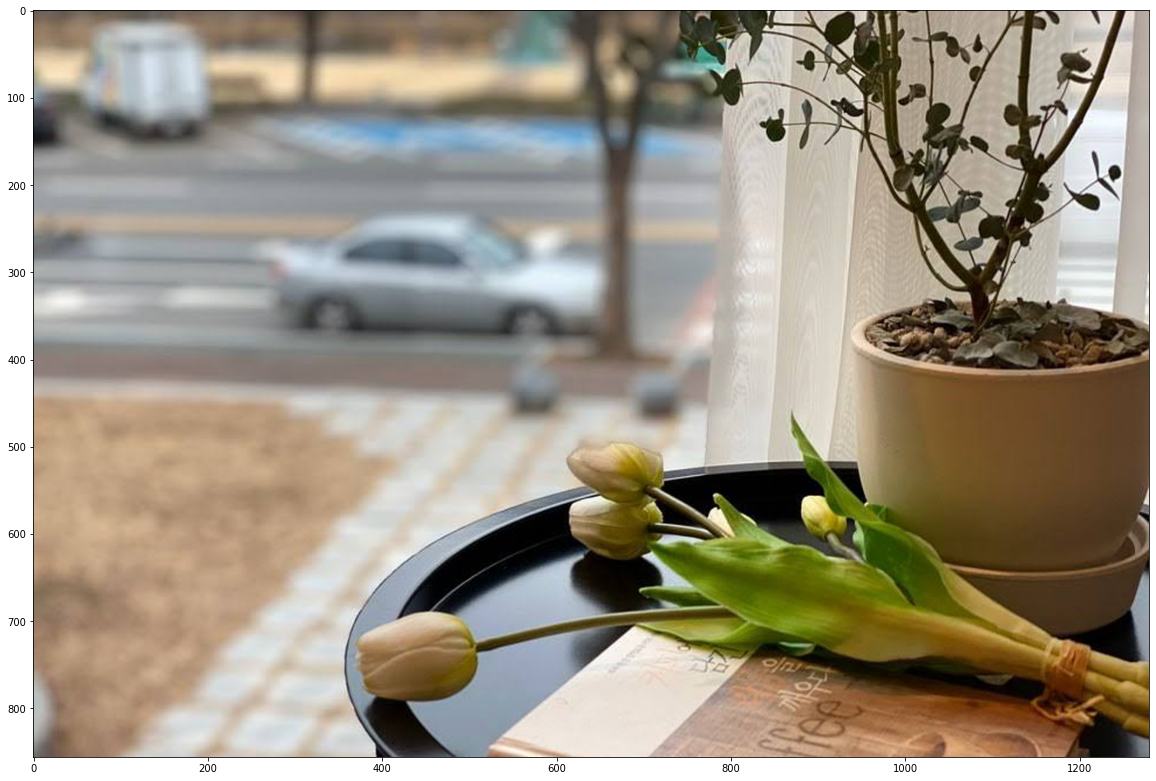

In [59]:
objs_url = 'https://lh3.googleusercontent.com/FxVY75GQxCahfUlNt-lWHDYCUCEJt2Gkko0AbmoBNw4H9UDx0kZOTjgFskQMtdPdcBgDIi6csu8PAsSdX6WGT4MsK1licMYaeYAlSWcNtG-ZaYzdKiGq4PX3m8gNEnwM4D_uMLeq4vdcCgpuFLZ5yN77miL6SJJLsQ128Ypqa2PPYFn6ORP7Gml3-KRMXny4dCkunFiAUOxG6kaf6efbzKu4_0YU1aChIB4do4RFKedzrMsN5_tsX9q3uuY-P3i6L3TcYCSD8aAIWhANlt67314tWRgqSieKCB4j1Qa96sZRk7TD0GmynGYFeMQOJ2tc9LV84_62pN4T9lO97aqLj6_D3yNUEdOfeNGRXESSxyTzPIqSn4VJkke0vH18xox0SsdWQbRPUl2Ak6kVLZTsJaqcF3Agk3zA88ELj_moI4QKQ8LJ9xQEvnAd7RLICK6q2E_fW1bVS7rrjmlo_C3QjFBzecAs7WNjn8cieKAXWHV5rQ_vkrKrqSNvXEnRXtLhBtRWPcZ0eeb2e1WpKomgnIlB6CYx80gnzm_AYQCn2nO3aM5xDqhA7CJfRnPgtz9hTkVSz00DCl4C2EsTLkYbDOozkCuw8g9MwNiwAA1i5kwB9QoLrZdFClG9LMgPSg-aGzoYzTQyCH9RBcVw8mkVv4Qr6kcTfLViosE8Ydp3-OyCRBKTx32jY-IxfoRfJnctLfIqD9iTfFoXTz8kjSwsFQ8FUaVm-yD1OJW9-hT15TbDPMjEhbj6Cq2ZHrMJQFqx3GNH1MSYZA-fPmItVbBVt6swbQDsZ1dbvVsRphRfpd4P2-IwpOOBqf7ZoFzXKsgTlqMCRiS0aLzFQeTrTG9CIPW4pbl-BuV9iFff-JIILyGTrPl9tCZ_C0253h-kfI0stblgLCN6kyMM1MjyDueAnoHwPcY62Mwnpf9tbc-aw2s7Yqjt1Q=w960-h721-s-no?authuser=0'
downloaded_image_path = download_and_resize_image(objs_url, 1280, 856, True) 

Found 100 objects.
Inference time:  1.4372565746307373


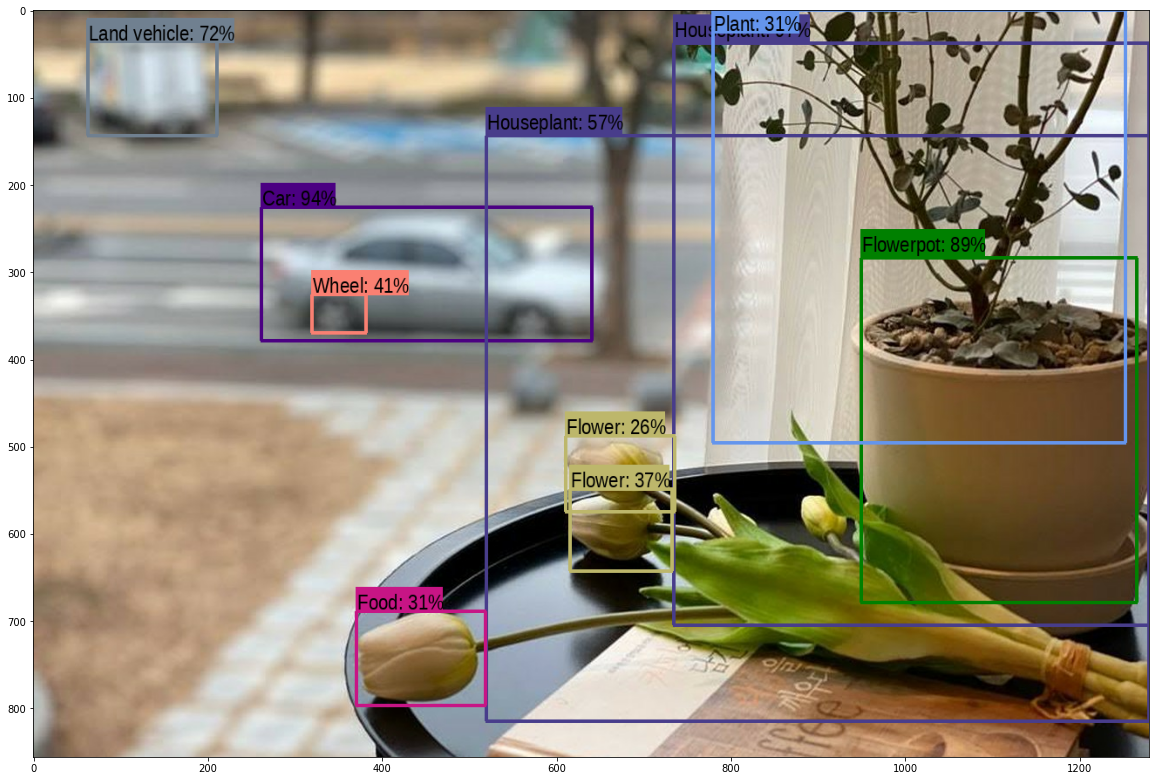

In [60]:
run_detector(detector, downloaded_image_path)

모델 주소 (https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1)

In [61]:
module_handle = 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1'

detector = hub.load(module_handle) # detector에 사용할 모듈 저장

In [63]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.cast(img, tf.uint8)
  return img

In [71]:
def run_detector(detector, path):
  img = load_img(path) 

  converted_img  = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]

# 소요시간 측정
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

# 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

# 이미지 내 박스로 entity, scores를 추가하여 출력
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_classes"], result["detection_scores"])

  display_image(image_with_boxes)

In [74]:
run_detector(detector, downloaded_image_path)

Found 1 objects.
Inference time:  0.07838225364685059


ValueError: too many values to unpack (expected 4)